## Importe

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import jupyter_black

In [2]:
# Run Black for Better Formatting
jupyter_black.load()

In [3]:
# Display all columns
pd.set_option("display.max_columns", None)

In [4]:
# Importing File
fifa = (
    pd.read_csv("players_fifa23.csv")
    .drop_duplicates(subset=["FullName", "Club"])
    .reset_index()
)

## Data Cleaning

In [5]:
# Setting Full Name as Index
fifa2 = fifa.set_index("FullName")

In [ ]:
# Selection of numeric attributes that are useful for player recommendation
fifa3 = fifa2._get_numeric_data()
fifa4 = fifa3.drop(
    [
        "index",
        "ID",
        "Growth",
        "TotalStats",
        "BaseStats",
        "ValueEUR",
        "WageEUR",
        "ReleaseClause",
        "ContractUntil",
        "ClubNumber",
        "ClubJoined",
        "OnLoad",
        "NationalNumber",
        "IntReputation",
        "GKDiving",
        "GKHandling",
        "GKKicking",
        "GKPositioning",
        "GKReflexes",
        "STRating",
        "LWRating",
        "LFRating",
        "CFRating",
        "RFRating",
        "RWRating",
        "CAMRating",
        "LMRating",
        "CMRating",
        "RMRating",
        "LWBRating",
        "CDMRating",
        "RWBRating",
        "LBRating",
        "CBRating",
        "RBRating",
        "GKRating",
    ],
    axis=1,
)

In [22]:
# Minmax Scaling
scaler = MinMaxScaler()

fifa5 = pd.DataFrame(
    scaler.fit_transform(fifa4), columns=fifa4.columns, index=fifa4.index
)

In [23]:
# Weighting: Overall-Skill & Potential should get a higher weight
fifa5["Overall"] = fifa5["Overall"] * 4
fifa5["Potential"] = fifa5["Potential"] * 2

## Recommendation System

In [24]:
# Instanciating of KNN and Fitting with Dataset
knn = NearestNeighbors(metric="cosine")
knn.fit(fifa5)

NearestNeighbors(metric='cosine')

In [25]:
# Calculation of Distance and Rank with KNN
distance, rank = knn.kneighbors(fifa5, 11)

In [26]:
# Buiding a Dict with Player Index and Player Name
id_name = fifa["FullName"].to_dict()

In [27]:
# Column with Player Name and Club
id_name_club = fifa[["FullName", "Club"]].drop_duplicates()
id_name_club["Name and Club"] = (
    id_name_club.FullName + " " + "(" + id_name_club.Club + ")"
)
id_name_club = id_name_club["Name and Club"].to_dict()

In [28]:
# Building a DataFrame with the Distances between Players
dist_df = pd.DataFrame(
    columns=[f"rank_{i}" for i in range(1, 11)],
    index=fifa5.index,
    data=distance[:, 1:],
)

In [29]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name
similar_df = pd.DataFrame(
    columns=[f"rank_{i}_name" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name))

In [30]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name with Club
similar_with_club_df = pd.DataFrame(
    columns=[f"rank_{i}_name_club" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name_club))

In [31]:
# Joining the different DataFrames together
df_data = fifa4.join(similar_df).join(dist_df).join(similar_with_club_df)

In [32]:
# Droping rows with Nans
df_data = df_data.dropna(how="any")

In [35]:
def similar_player(player_name):
    player_name = df_data[df_data.index == player_name].index[0]

    ## Bar chart
    plt.figure(figsize=(12, 6))

    Xaxis = df_data.loc[player_name].values[-20:-10]
    Yaxis = df_data.loc[player_name].values[-10:]

    fig = sns.barplot(data=df_data, x=Xaxis, y=Yaxis, palette="mako")
    fig.set_title('Players similar to  " ' + str(player_name) + ' "')
    plt.show()

    ## Table display

    display_df = pd.concat(
        [
            df_data[df_data.index == player_name],
            df_data.loc[df_data.loc[player_name].values[42:52]],
        ]
    ).iloc[:, :42]

    display(display_df)

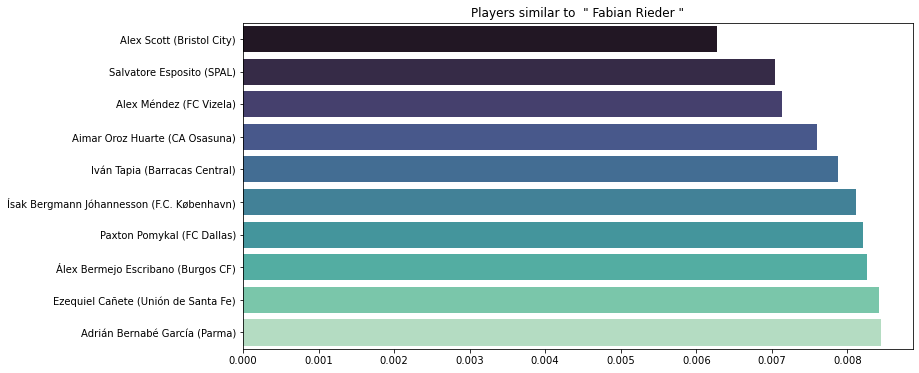

,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fabian Rieder,20,179,74,68,83,3,2,69,61,69,70,50,61,54,58,41,74,42,70,68,72,72,72,70,68,70,52,83,68,62,74,59,65,50,52,63,73,51,70,45,55,53
Alex Scott,18,178,68,69,87,3,3,73,60,69,74,59,63,66,61,51,72,53,74,65,63,69,70,75,72,84,62,83,63,60,74,60,58,56,57,62,69,52,72,59,63,60
Salvatore Esposito,21,178,70,68,79,3,2,64,60,70,65,59,58,59,55,51,77,51,61,68,67,70,68,63,64,71,62,74,62,51,75,51,68,55,61,68,70,64,65,60,60,61
Alex Méndez,21,178,70,67,77,3,2,64,56,70,68,49,57,65,54,52,72,53,69,65,68,74,70,61,66,61,63,71,57,58,69,56,55,46,58,65,71,66,67,40,49,57
Aimar Oroz Huarte,20,177,73,66,79,3,3,67,64,68,65,52,55,61,63,44,73,45,64,61,59,71,65,74,62,69,61,68,69,56,66,51,66,53,55,62,67,58,65,52,56,38
Iván Tapia,23,179,70,69,77,3,3,70,64,69,70,52,66,60,65,51,73,50,68,70,70,65,73,69,71,73,60,71,68,62,70,68,59,59,46,69,72,65,69,54,55,52
Ísak Bergmann Jóhannesson,19,180,72,67,82,3,3,74,61,67,69,57,68,64,59,45,69,58,66,67,64,64,68,72,76,79,64,82,65,71,85,60,64,67,58,66,69,58,69,60,58,58
Paxton Pomykal,22,173,73,69,80,3,2,74,57,70,72,61,69,65,51,42,74,56,73,63,65,69,67,77,71,81,66,82,62,68,80,67,63,58,51,65,70,59,73,71,66,57
Álex Bermejo Escribano,23,183,76,69,78,3,3,73,68,65,71,53,62,55,68,54,70,51,72,63,57,66,70,77,70,76,62,72,73,60,71,64,69,48,47,65,66,63,74,49,58,56


In [36]:
similar_player("Fabian Rieder")